### ¿Qué es la validación cruzada (*cross-validation*)?

La validación cruzada es una técnica de evaluación de modelos de aprendizaje automático que permite estimar de manera más robusta el rendimiento de un modelo en datos no vistos. Su objetivo principal es reducir el sesgo y la varianza asociados al uso de una única partición entrenamiento-prueba (como en el *hold-out*), especialmente cuando la cantidad de datos es limitada.

---

### ¿Por qué es necesaria?

1. **Sobreajuste en la evaluación**: Si dividimos una vez los datos en entrenamiento y prueba, el resultado de la métrica (ej. exactitud) puede depender mucho de esa partición específica.
2. **Uso eficiente de los datos**: En *hold-out*, una parte sustancial de los datos no se usa para entrenar; con pocos datos, esto perjudica el aprendizaje.
3. **Estabilidad del rendimiento**: La validación cruzada promedia el rendimiento sobre múltiples particiones, dando una estimación más confiable.

---

### Tipos comunes de validación cruzada

#### 1. [**K-fold cross-validation**](https://medium.com/@pacosun/cross-validation-techniques-ensuring-your-model-generalizes-well-2f5b4f58be0f)
- Se divide el conjunto de datos en *k* particiones (*folds*) de tamaño aproximadamente igual.
- Se entrena el modelo *k* veces: en cada iteración, se usa *k-1* folds para entrenar y el fold restante para validar.
- El rendimiento final es la media (y desviación estándar) de las *k* métricas obtenidas.

Ventaja: Usa todos los datos para entrenar y validar, sin solapamiento entre folds.

#### 2. [**Leave-One-Out (LOO)**](https://medium.com/@pacosun/one-out-all-in-leave-one-out-cross-validation-explained-409df5ff6385)
- Caso particular de *k-fold* con *k = n* (número de muestras).
- Cada iteración deja una única observación para validar.
- Muy costoso computacionalmente, pero útil con conjuntos muy pequeños.

#### 3. [**Stratified K-Fold**](https://medium.com/@pacosun/stratified-k-fold-cross-validation-when-balance-matters-c28b)
- Mantiene la proporción de clases en cada fold (esencial para problemas de clasificación desbalanceados).

#### 4. [**TimeSeriesSplit**](https://medium.com/@pacosun/respect-the-order-cross-validation-in-time-series-7d12beab79a1)
- Para datos temporales: respeta el orden cronológico; el fold de validación siempre ocurre *después* del entrenamiento.


### Implementación en Python (con scikit-learn)

[_scoring names_](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-string-names)

In [21]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Cargar datos de ejemplo
X, y = load_iris(return_X_y=True)

In [25]:
print("clases:\t", np.unique(y))

# Modelo
model = RandomForestClassifier(random_state=42)

# Estrategia de validación cruzada (estratificada, k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular puntuaciones (exactitud por defecto)
scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc_ovo')

print(f"Puntuaciones por fold: {scores}")
print(f"Exactitud media: {scores.mean():.3f} ± {scores.std():.3f}")

clases:	 [0 1 2]
Puntuaciones por fold: [1.         1.         0.99       1.         0.98166667]
Exactitud media: 0.994 ± 0.007



**Notas importantes:**
- `cross_val_score` maneja internamente el entrenamiento y la evaluación en cada fold.
- No devuelve el modelo ajustado; si necesitas el modelo final, entrena después con todos los datos.
- Usa `scoring` para especificar otras métricas: `'f1'`, `'roc_auc'`, `'neg_mean_squared_error'`, etc.

### Extensión: Cross-validation con pipeline (evita *data leakage*)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# cross_validate permite múltiples métricas y tiempos
results = cross_validate(
    pipeline, X, y, 
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    return_train_score=True
)

print("Exactitud en validación:", results['test_accuracy'].mean())
print("F1 en validación:", results['test_f1_macro'].mean())

Exactitud en validación: 0.9466666666666667
F1 en validación: 0.9464317359054201


_Esto garantiza que la estandarización se ajuste *solo* con los datos de entrenamiento en cada fold —evitando filtración de información (*leakage*) desde la validación._

### Recomendaciones didácticas para tus clases

- **Compara con hold-out**: muestra empíricamente cómo varía la exactitud con distintas semillas en hold-out vs la estabilidad en CV.
- **Menciona los límites**: CV no sustituye una prueba final *independiente* (ej. datos futuros o de otra fuente).

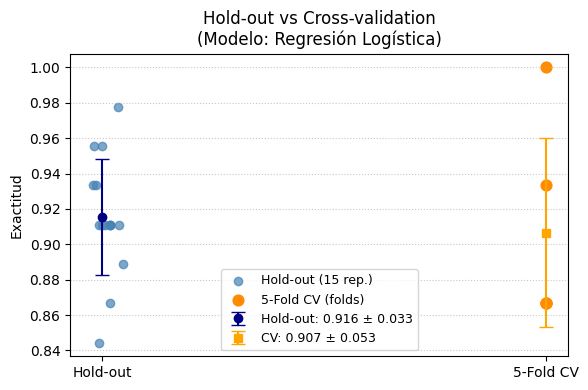

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Datos pequeños y reproducibles
X, y = make_classification(n_samples=150, n_features=5, n_classes=2, 
                           weights=[0.6, 0.4], random_state=1)

model = LogisticRegression(max_iter=1000)

# Hold-out: 15 repeticiones (más ligero)
ho_scores = []
for rs in range(15):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, 
                                               stratify=y, random_state=rs)
    model.fit(X_tr, y_tr)
    ho_scores.append(model.score(X_te, y_te))
ho_scores = np.array(ho_scores)

# 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(model, X, y, cv=cv)

# Estadísticos
ho_mean, ho_std = ho_scores.mean(), ho_scores.std()
cv_mean, cv_std = cv_scores.mean(), cv_scores.std()

# Gráfico simple
fig, ax = plt.subplots(figsize=(6, 4))

# Hold-out
x_ho = np.full_like(ho_scores, 0.0)
ax.scatter(x_ho + np.random.normal(0, 0.02, ho_scores.shape), ho_scores,
           color='steelblue', alpha=0.7, label='Hold-out (15 rep.)')
ax.errorbar(0, ho_mean, yerr=ho_std, fmt='o', color='navy', 
            capsize=5, label=f'Hold-out: {ho_mean:.3f} ± {ho_std:.3f}')

# CV
x_cv = np.full_like(cv_scores, 1.0)
ax.scatter(x_cv, cv_scores, color='darkorange', s=60, 
           label='5-Fold CV (folds)')
ax.errorbar(1, cv_mean, yerr=cv_std, fmt='s', color='orange', 
            capsize=5, label=f'CV: {cv_mean:.3f} ± {cv_std:.3f}')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Hold-out', '5-Fold CV'])
ax.set_ylabel('Exactitud')
ax.set_title('Hold-out vs Cross-validation\n(Modelo: Regresión Logística)')
ax.legend(fontsize=9)
ax.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

##  ¿Por qué elegir *Cross-validation*?

Aunque la media es un poco más baja (0.907), **CV es más confiable y robusto**, como lo demuestra el gráfico.

### Ventajas visibles en el gráfico:
1. **Uso completo de los datos**:  
   - Cada punto de datos participa en entrenamiento y validación en diferentes folds → estimación más representativa del rendimiento real.

2. **Transparencia en la variabilidad**:  
   - Los 5 puntos naranjas muestran claramente cómo varía el rendimiento según el fold → permite detectar si el modelo es inestable en ciertas particiones.

3. **Estimación más honesta del rendimiento general**:  
   - Aunque la media es ligeramente menor, **la desviación estándar mayor (±0.053) refleja mejor la incertidumbre real** del modelo.  
   - Es decir: CV no “engaña” con un buen resultado accidental.

4. **Ideal para comparar modelos**:  
   - Si vas a comparar varios modelos, CV te da una métrica más justa porque evalúa cada modelo bajo las mismas condiciones (mismos folds).

---

##  Resumen comparativo (según el gráfico)

| Característica             | Hold-out (15 rep.)          | 5-Fold CV                   |
|---------------------------|-----------------------------|-----------------------------|
| **Media de exactitud**     | 0.916                       | 0.907                       |
| **Desv. estándar**         | ±0.033 (menor variabilidad) | ±0.053 (mayor variabilidad) |
| **Consistencia**           | Más estable entre repeticiones | Muestra variabilidad real |
| **Uso de datos**           | Solo 70% en entrenamiento   | 100% usado en entrenamiento |
| **Robustez**               | Menor (depende de la partición) | Mayor (promedia múltiples escenarios) |
| **Recomendado para**       | Datos grandes, prototipado rápido | Modelos finales, comparación justa |


---

> “Un modelo puede parecer mejor con *hold-out*... pero eso no significa que sea más confiable. La validación cruzada nos dice la verdad, aunque a veces duela.”


> “Si tienes muchos datos y necesitas velocidad → *hold-out*. Si quieres estar seguro de que tu modelo generaliza bien → *cross-validation*.”
